In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import datetime
import time
from pykalman import KalmanFilter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
f1 = sys.argv[1]
# f1 = 'sysinfo.csv'

In [3]:
def to_timestamp_single(date):
    return date.timestamp()
to_timestamp = np.vectorize(to_timestamp_single)

In [4]:
cpu_data = pd.read_csv(f1, parse_dates=[4])
cpu_data['timestamp_value'] = cpu_data['timestamp'].apply(to_timestamp)

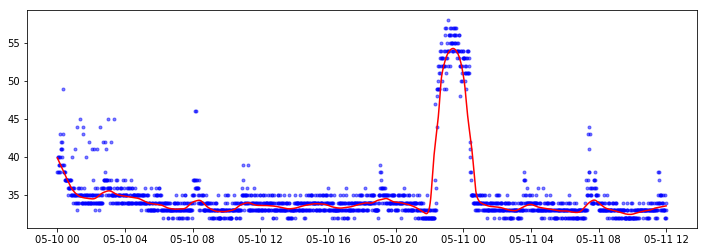

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)

loess_smoothed = lowess(cpu_data['temperature'], cpu_data['timestamp_value'], frac = 0.04)
plt.plot(cpu_data['timestamp'], loess_smoothed[:, 1], 'r-')

# plt.show()

In [6]:
kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1']]

initial_state = kalman_data.iloc[0]
observation_covariance = np.diag([4, 0.1, 0.015]) ** 2
transition_covariance = np.diag([1, 3, 4]) ** 2 
transition = [[1, -1, 0.7], [0, 0.6, 0.03], [0, 1.3, 0.8]]

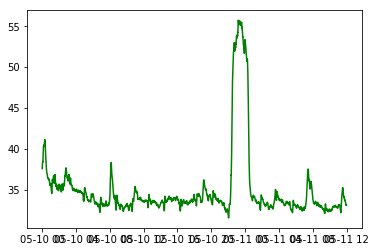

In [7]:
kf = KalmanFilter(initial_state_mean=initial_state,
                initial_state_covariance=observation_covariance,
                observation_covariance=observation_covariance,
                transition_covariance=transition_covariance,
                transition_matrices=transition)
kalman_smoothed,_ = kf.smooth(kalman_data)
plt.plot(cpu_data['timestamp'], kalman_smoothed[:, 0], 'g-')

# plt.show()

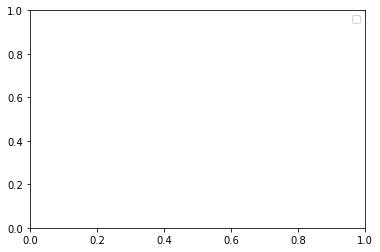

In [8]:
plt.legend(['Temperature Readings', 'LOESS smoothing line', 'Kalman Smoothing line'])
plt.savefig('cpu.svg')